In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import train_test_split
import warnings

In [ ]:
ds = pd.read_csv("/content/sample_data/movie_train.csv")

In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')

    return df

In [ ]:
class Preprocess:
    def __init__(self, ds: pd.DataFrame, drop_low_corr):
        self.ds = ds
        self.n_clusters = [5, 10]
        self.random_state = 42
        self.show_corr = True
        self.correlation_threshold = 0.1
        self.drop_low = drop_low_corr

    def label_genres(self, ds):
        mlb = MultiLabelBinarizer()
        ds['genres'] = ds['genres'].str.split('|')
        genre_vectors = mlb.fit_transform(self.ds['genres'])
        genre_names = [("genre_" + x) for x in mlb.classes_]
        genre_columns = pd.DataFrame(genre_vectors, columns=genre_names)
        return pd.concat([ds, genre_columns], axis=1)

    def impute_numerical(self, ds):
        ds = ds.fillna(ds.median())
        return ds

    def process_plot(self, ds):

        tfidf_vectorizer = TfidfVectorizer(max_features=1000)

        ds['plot_keywords'] = ds['plot_keywords'].str.split('|')
        ds['plot_keywords'] = ds['plot_keywords'].fillna('[]')
        ds['plot_keywords'] = ds['plot_keywords'].apply(lambda x: " ".join(x))

        tfidf_matrix = tfidf_vectorizer.fit_transform(ds['plot_keywords'])

        feature_names = tfidf_vectorizer.get_feature_names_out()

        for i in self.n_clusters:
          kmeans = KMeans(n_clusters=i, random_state = self.random_state)
          cluster_labels = kmeans.fit_predict(tfidf_matrix)
          ds['cluster_label_' + str(i)] = cluster_labels
        return ds

    def assign_sales(self, ds):
        gross_mean = ds['gross'].mean()
        gross_std = ds['gross'].std()

        low_threshold = gross_mean - gross_std
        high_threshold = gross_mean + gross_std

        ds['target'] = 1

        ds.loc[ds['gross'] < low_threshold, 'target'] = 0

        ds.loc[ds['gross'] > high_threshold, 'target'] = 2
        return ds

    def plot_corr(self, ds):
        sns.heatmap(ds.corr(), annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.figure(figsize=(24, 20))
        plt.show()

    def compile(self):
        ds = self.ds.copy()
        ds = self.label_genres(ds)
        ds = self.impute_numerical(ds)
        ds = self.process_plot(ds)
        ds = self.assign_sales(ds)

        ds['language'] = ds['language'].fillna('None')
        ds['color'] = ds['color'].fillna('None')

        temp =  ds.drop(columns=['genres', 'movie_imdb_link', 'movie_title', 'plot_keywords', 'gross', 'target'])
        ds = ds.drop(columns=['genres', 'movie_imdb_link', 'movie_title', 'plot_keywords', 'gross'])

        ds = reduce_mem_usage(ds)

        categorical_columns = temp.select_dtypes(include=[object]).columns

        encoder = BinaryEncoder(cols=categorical_columns, drop_invariant=True)
        ds = encoder.fit_transform(ds)
        correlation_matrix = ds.corr()
        target_corr = correlation_matrix['target']

        if self.drop_low:
          low_corr_columns = target_corr[target_corr < self.correlation_threshold].index.tolist()
          prev_shape = ds.shape[1]
          ds = ds.drop(columns=low_corr_columns)
          print("Dropped " + str(abs(ds.shape[1] - prev_shape)) + ' columns')

        if self.show_corr:
          self.plot_corr(ds)

        return ds

<ipython-input-325-14c40378322f>:19: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ds = ds.fillna(ds.median())
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Memory usage of dataframe is 2.31 MB
Memory usage after optimization is: 0.69 MB
Decreased by 70.00%
Dropped 98 columns


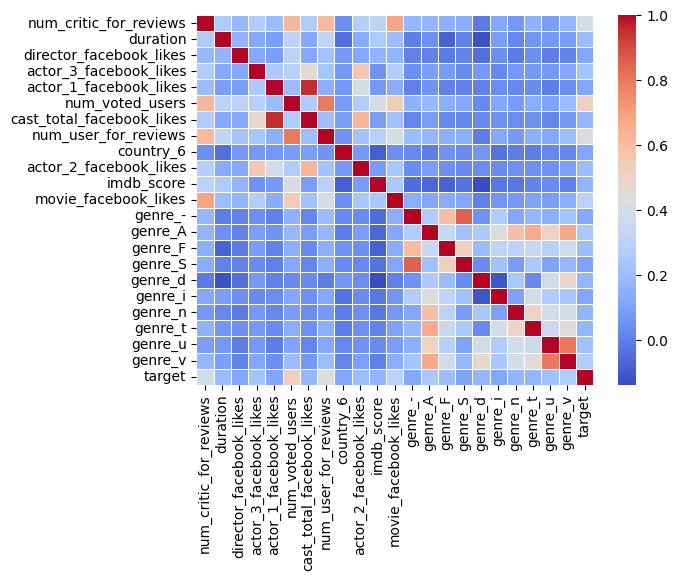

<Figure size 2400x2000 with 0 Axes>

num_critic_for_reviews       False
duration                     False
director_facebook_likes      False
actor_3_facebook_likes       False
actor_1_facebook_likes       False
num_voted_users              False
cast_total_facebook_likes    False
num_user_for_reviews         False
country_6                    False
actor_2_facebook_likes       False
imdb_score                   False
movie_facebook_likes         False
genre_-                      False
genre_A                      False
genre_F                      False
genre_S                      False
genre_d                      False
genre_i                      False
genre_n                      False
genre_t                      False
genre_u                      False
genre_v                      False
target                       False
dtype: bool

In [ ]:
p = Preprocess(ds, drop_low_corr = True)
d = p.compile()
d.isna().any()

In [ ]:
def split_data(ds: pd.DataFrame, target_column: str):
  y = ds[target_column]
  X = ds.drop(target_column, axis=1)
  return X, y

X, y = split_data(d, 'target')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, shuffle=True)

scaler = StandardScaler()
scaledX_train = scaler.fit_transform(X_train)
scaledX_test = scaler.transform(X_test)

In [ ]:
n_components = 22

pca = PCA(n_components=n_components,whiten=True)

pcaXTrain = pca.fit_transform(scaledX_train)
pcaXTest = pca.fit_transform(scaledX_test)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
class Classifier:
    def __init__(self, train, labels, header):
        self.train = train
        self.labels = labels
        self.header = header
        self.results = {}
        self.best_model = None
        self.random_state = 42
        self.predictions = None
        self.confusion_mat = None

    def test_model(self, clf):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        accuracy_scores = cross_val_score(clf, self.train, self.labels, cv=cv, scoring='accuracy')
        scores = [accuracy_scores.mean()]
        return scores

    def compare_models(self):
        clf = LogisticRegression()
        self.results["logistic-regression"] = self.test_model(clf)
        print("Logistic Regression: " + str(self.results["logistic-regression"]))

        clf = RandomForestClassifier()
        self.results["random-forest"] = self.test_model(clf)
        print("Random Forest: " + str(self.results["random-forest"]))

        clf = GradientBoostingClassifier()
        self.results["gradient-boosting"] = self.test_model(clf)
        print("Gradient Boosting: " + str(self.results["gradient-boosting"]))

        clf = KNeighborsClassifier()
        self.results["k-neighbors"] = self.test_model(clf)
        print("K-Neighbors: " + str(self.results["k-neighbors"]))

        estimators = [
            ('logistic-regression', LogisticRegression()),
            ('random-forest', RandomForestClassifier()),
            ('gradient-boosting', GradientBoostingClassifier()),
            ('k-neighbors', KNeighborsClassifier())
        ]

        voting_clf = VotingClassifier(estimators)
        self.results["voting-classifier"] = self.test_model(voting_clf)
        print("Voting Classifier: " + str(self.results["voting-classifier"]))

        models = estimators.copy()

        models.append(('voting-classifier', voting_clf))

        best_model_name = max(self.results, key=lambda k: self.results[k][0])
        self.best_model = models[[models[0] for models in models].index(best_model_name)][1]
        print("Best Model:", best_model_name)

    def predict_with_best_model(self, new_data, true_labels):
        if self.best_model is not None:
            self.best_model.fit(self.train, self.labels)
            predictions = self.best_model.predict(new_data)

            accuracy = accuracy_score(true_labels, predictions)
            class_report = classification_report(true_labels, predictions)

            self.predictions = predictions

            print("Prediction Shape: " + str(predictions.shape))
            print("True Shape: " + str(true_labels.shape))
            print("Accuracy: " + str(accuracy * 100) + '%')

            return predictions
        else:
            print("No best model selected. Please run compare_models first.")
            return None

    def plot_results(self):
        results_df = pd.DataFrame.from_dict(self.results, orient='index')
        results_df.columns = ["Accuracy"]
        results_df = results_df.sort_values(by=["Accuracy"], ascending=False)
        results_df.plot(kind="bar", title=self.header)
        plt.xlabel("Model")
        plt.ylabel("Accuracy")
        plt.ylim(0.875, 1.0)
        plt.show()


Baseline Model

In [ ]:
baseline = Classifier(X_train, y_train, header = "Baseline Model")

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    baseline.compare_models()

Logistic Regression: [0.9002375630067938]
Random Forest: [0.933392943239097]
Gradient Boosting: [0.9316173570019725]
K-Neighbors: [0.9046763094455402]
Voting Classifier: [0.9224391847468769]
Best Model: random-forest


In [ ]:
baseline.predict_with_best_model(X_test, y_test)

Prediction Shape: (1665,)
True Shape: (1665,)
Accuracy: 92.43243243243244%


array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

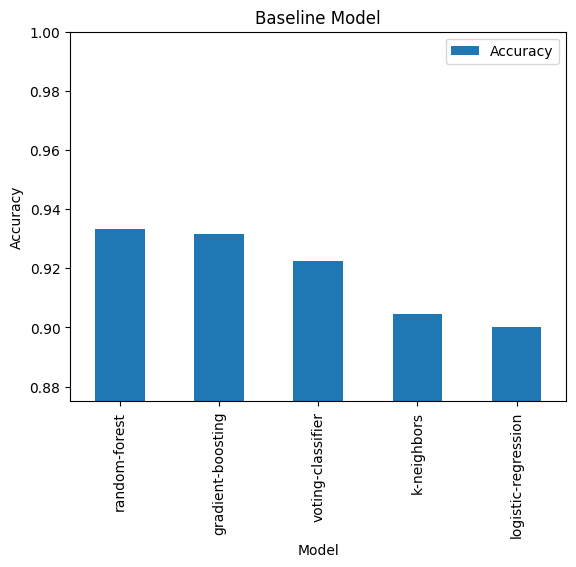

In [ ]:
baseline.plot_results()

PCA Model

In [ ]:
pca_model = Classifier(pcaXTrain, y_train, header = "PCA Model")

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pca_model.compare_models()

Logistic Regression: [0.9248056103440719]
Random Forest: [0.9316151654613194]
Gradient Boosting: [0.9307271531886917]
K-Neighbors: [0.9188880122726276]
Voting Classifier: [0.9289498137190446]
Best Model: random-forest


In [ ]:
pca_model.predict_with_best_model(pcaXTest, y_test)

Prediction Shape: (1665,)
True Shape: (1665,)
Accuracy: 90.2102102102102%


array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

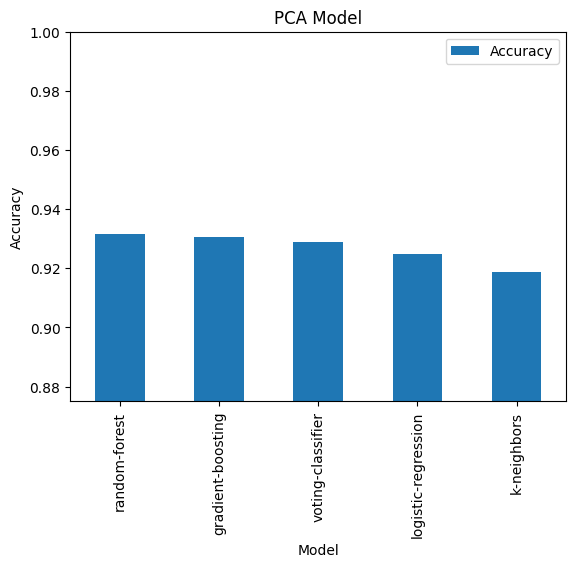

In [ ]:
pca_model.plot_results()